In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from matplotlib import pyplot as plt

In [86]:
train = pd.read_csv('data/train.csv')
# test = pd.read_csv('data/test.csv')

In [87]:
train = train.dropna()
# test = test.dropna()

In [88]:
train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

split_size = 50000
train = pd.concat([ train[train['is_duplicate'] == 1][:split_size], train[train['is_duplicate'] == 0][:split_size]])

In [89]:
train[:15]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


![Similarity](https://miro.medium.com/max/926/1*u2ZZPh5er5YbmOg7k-s0-A.png)

In [90]:
# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

### Drop the empty rows

In [91]:
train.drop(train.loc[train['question1'] == ' '].index,inplace=True)
train.drop(train.loc[train['question2'] == ' '].index,inplace=True)
# test.drop(test.loc[test['question1'] == ' '].index,inplace=True)
# test.drop(test.loc[test['question2'] == ' '].index,inplace=True)

### Lowecase and clean them

In [92]:
%%time
train['question1'] = train['question1'].apply(lambda x: text_to_wordlist(text=x))
train['question2'] = train['question2'].apply(lambda x: text_to_wordlist(text=x))
# test['question1'] = test['question1'].apply(lambda x: text_to_wordlist(text=x))
# test['question2'] = test['question2'].apply(lambda x: text_to_wordlist(text=x))

CPU times: user 30.5 s, sys: 159 ms, total: 30.7 s
Wall time: 30.7 s


### Let's find some features

**Sources:**
* [StudyCase](https://github.com/ishritam/Quora-question-pair-similarity/blob/master/Quora%20Case%20Study.ipynb)

**Features:**
* freq_qid1 : Frequency of qid1's
* freq_qid2 : Frequency of qid2's
* q1len : Length of q1
* q2len : Length of q2
* q1_n_words : Number of words in Question 1
* q2_n_words : Number of words in Question 2
* word_Common : (Number of common unique words in Question 1 and Question 2)
* word_Total : (Total num of words in Question 1 + Total num of words in Question 2)
* word_share : (word_common)/(word_Total)
* freq_q1+freq_q2 : sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 : absolute difference of frequency of qid1 and qid2
* cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
* cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
* csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
* csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2 
* ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2 
* ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2 
* last_word_eq : Check if First word of both questions is equal or not 
* first_word_eq : Check if First word of both questions is equal or not 
* abs_len_diff : Abs. length difference
* mean_len : Average Token Length of both Questions 
* fuzz_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* fuzz_partial_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* token_sort_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* token_set_ratio : [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy#usage)
* longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
* wmd: Word Mover’s Distance between two document
* jaccard: Similarity Distance

In [93]:
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords

In [94]:
try:
    import distance
except:
    !pip install distance
    import distance

In [95]:
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

In [96]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

#### Full Features extraction

In [97]:
%%time
train['freq_qid1'] = train.groupby('qid1')['qid1'].transform('count') 
train['freq_qid2'] = train.groupby('qid2')['qid2'].transform('count')
train['q1len'] = train['question1'].str.len() 
train['q2len'] = train['question2'].str.len()
train['q1_n_words'] = train['question1'].apply(lambda row: len(row.split(" ")))
train['q2_n_words'] = train['question2'].apply(lambda row: len(row.split(" ")))
train['word_Common'] = train.apply(normalized_word_Common, axis=1)
train['word_Total'] = train.apply(normalized_word_Total, axis=1)
train['word_share'] = train.apply(normalized_word_share, axis=1)
train['freq_q1+q2'] = train['freq_qid1']+train['freq_qid2']
train['freq_q1-q2'] = abs(train['freq_qid1']- train['freq_qid2'])

token_features = train.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)  

train["cwc_min"]       = list(map(lambda x: x[0], token_features))
train["cwc_max"]       = list(map(lambda x: x[1], token_features))
train["csc_min"]       = list(map(lambda x: x[2], token_features))
train["csc_max"]       = list(map(lambda x: x[3], token_features))
train["ctc_min"]       = list(map(lambda x: x[4], token_features))
train["ctc_max"]       = list(map(lambda x: x[5], token_features))
train["last_word_eq"]  = list(map(lambda x: x[6], token_features))
train["first_word_eq"] = list(map(lambda x: x[7], token_features))
train["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
train["mean_len"]      = list(map(lambda x: x[9], token_features))

CPU times: user 1min 36s, sys: 1.19 s, total: 1min 37s
Wall time: 1min 38s


In [98]:
%%time
train["token_set_ratio"]       = train.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
train["token_sort_ratio"]      = train.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
train["fuzz_ratio"]            = train.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
train["fuzz_partial_ratio"]    = train.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
train["longest_substr_ratio"]  = train.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

CPU times: user 6min 28s, sys: 3.08 s, total: 6min 31s
Wall time: 6min 33s


In [99]:
train[:5]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0,4,1,53,90,...,0.470585,0.0,1.0,5.0,14.5,86,63,67,75,0.611111
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0,1,1,49,62,...,0.000000,0.0,0.0,3.0,12.5,36,36,35,39,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,3,1,74,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,45,56,0.175000


In [100]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [101]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

**Differences between Jaccard Similarity and Cosine Similarity:**
* Jaccard similarity takes only unique set of words for each sentence / document while cosine similarity takes total length of the vectors. (these vectors could be made from bag of words term frequency or tf-idf)
* This means that if you repeat the word “friend” in Sentence 1 several times, cosine similarity changes but Jaccard similarity does not. For ex, if the word “friend” is repeated in the first sentence 50 times, cosine similarity drops to 0.4 but Jaccard similarity remains at 0.5.
* Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity. For two product descriptions, it will be better to use Jaccard similarity as repetition of a word does not reduce their similarity.

#### This approach needs more resources (e.g. 5k rows in 20mins => we have 400k+)

```python
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

train['q1_sent_vec'] = embed(train['question1'])
train['q2_sent_vec'] = embed(train['question2'])

```
Let's try to fit this approach into a model after we define more models

**Sources:**

* [WMD Tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/WMD_tutorial.ipynb)

In [102]:
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import gensim.downloader as api
from nltk import word_tokenize

In [103]:
glove = api.load('glove-wiki-gigaword-50')

Activate normalasation

In [104]:
glove.init_sims(replace=True)

In [105]:
glove.wmdistance('this is a sentence', 'this is a sentence')

0.0

In [106]:
glove.wmdistance('this is a sentence', 'no this is also a sentence')

0.14988077806462458

In [107]:
def wmd(q1, q2,model): 
    q1 = str(q1).lower().split() 
    q2 = str(q2).lower().split() 
    q1 = [w for w in q1 if w not in STOP_WORDS] 
    q2 = [w for w in q2 if w not in STOP_WORDS]
    return model.wmdistance(q1, q2) 

Source:
 * [WMD](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.wmdistance.html)
 
***Word Mover’s Distance between two documents***

In [108]:
%%time
train['wmd'] = train.apply(lambda x: wmd(x['question1'], x['question2'],glove),axis=1)

CPU times: user 4min 57s, sys: 1.64 s, total: 4min 59s
Wall time: 5min


In [109]:
%%time
train['jaccard'] = train.apply(lambda x: get_jaccard_sim(x['question1'], x['question2']),axis=1)

CPU times: user 12.1 s, sys: 253 ms, total: 12.4 s
Wall time: 12.4 s


In [110]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
to_be_scaled = [
    'freq_q1+q2',
    'freq_q1-q2',
    'freq_qid1',
    'freq_qid2',
    'q1_n_words',
    'q2_n_words',
    'word_Common',
    'word_Total',
    'last_word_eq',
    'first_word_eq',
    'abs_len_diff',
    'mean_len',
    'q1len',
    'q2len',
    'fuzz_partial_ratio',
    'token_set_ratio',
    'token_sort_ratio',
    'fuzz_ratio',
]
train[to_be_scaled] = scaler.fit_transform(train[to_be_scaled])

In [111]:
train[:5]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,wmd,jaccard
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.000000,0.0,0.107084,0.049209,...,1.0,0.008772,0.093863,1.00,0.93,0.93,1.00,0.982759,0.147856,0.916667
1,1,3,4,what is the story of kohinoor koh - i - noor d...,what would happen if the indian government sto...,0,0.061224,0.0,0.085667,0.078207,...,1.0,0.021930,0.104693,0.86,0.63,0.67,0.75,0.611111,0.554370,0.444444
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.000000,0.0,0.118616,0.050967,...,1.0,0.017544,0.086643,0.66,0.66,0.54,0.54,0.166667,0.562440,0.200000
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 math is d...,0,0.000000,0.0,0.079077,0.053603,...,0.0,0.013158,0.090253,0.36,0.36,0.35,0.39,0.040000,1.184910,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.040816,0.0,0.120264,0.033392,...,1.0,0.026316,0.072202,0.67,0.47,0.45,0.56,0.175000,0.795780,0.250000


In [112]:
features_list = train.columns.tolist()[6:]
features_list

['freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio',
 'wmd',
 'jaccard']

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(train[features_list], train['is_duplicate'], test_size=0.33, random_state=42,stratify=train['is_duplicate'])

In [115]:
import xgboost as xgb

# Set our parameters for xgboost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.02,
    'max_depth': 4,
    }

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68448	test-logloss:0.68478
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.61607	test-logloss:0.61606
[20]	train-logloss:0.56617	test-logloss:0.56602
[30]	train-logloss:0.52820	test-logloss:0.52830
[40]	train-logloss:0.49920	test-logloss:0.49921
[50]	train-logloss:0.47696	test-logloss:0.47686
[60]	train-logloss:0.45919	test-logloss:0.45914
[70]	train-logloss:0.44477	test-logloss:0.44510
[80]	train-logloss:0.43323	test-logloss:0.43351
[90]	train-logloss:0.42371	test-logloss:0.42430
[100]	train-logloss:0.41608	test-logloss:0.41673
[110]	train-logloss:0.40958	test-logloss:0.41046
[120]	train-logloss:0.40434	test-logloss:0.40521
[130]	train-logloss:0.39994	test-logloss:0.40085
[140]	train-logloss:0.39614	test-logloss:0.39720
[150]	train-logloss:0.39282	test-logloss:0.39404
[160]	train-logloss:0.39020	test-logloss:0.39132
[170]	train-logloss:0.38760	t

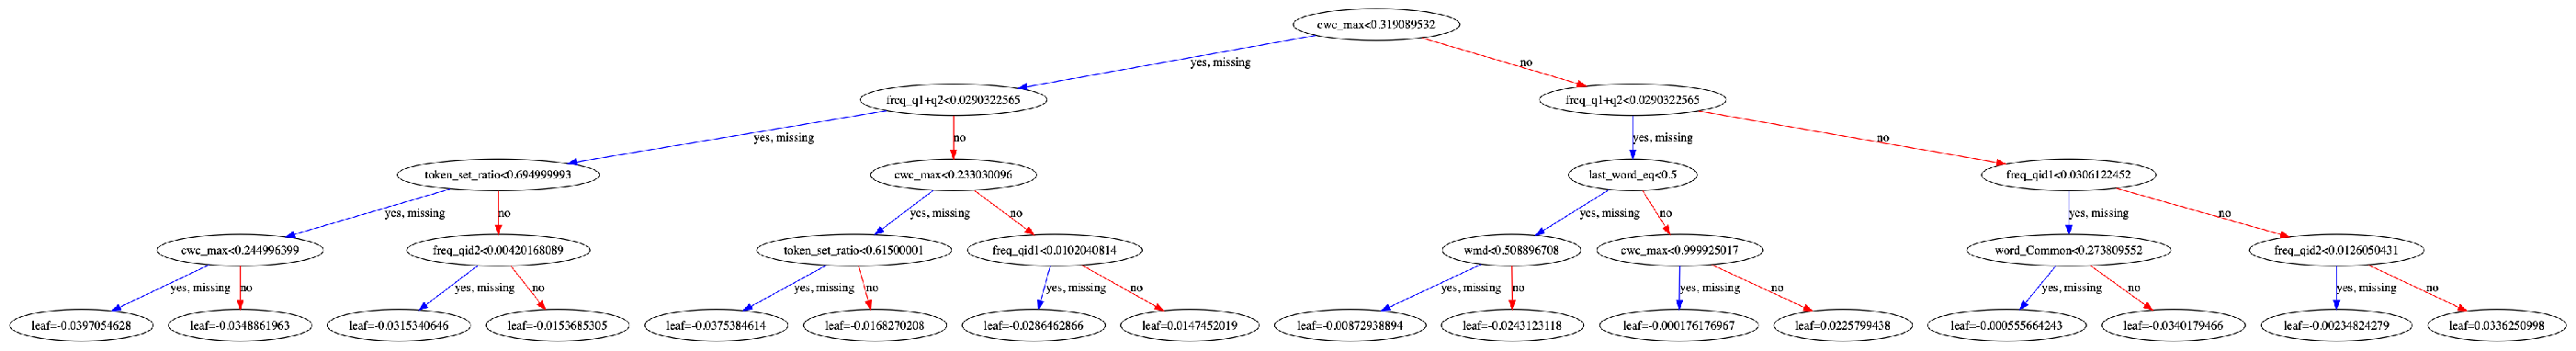

In [124]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 100]
plt.show()

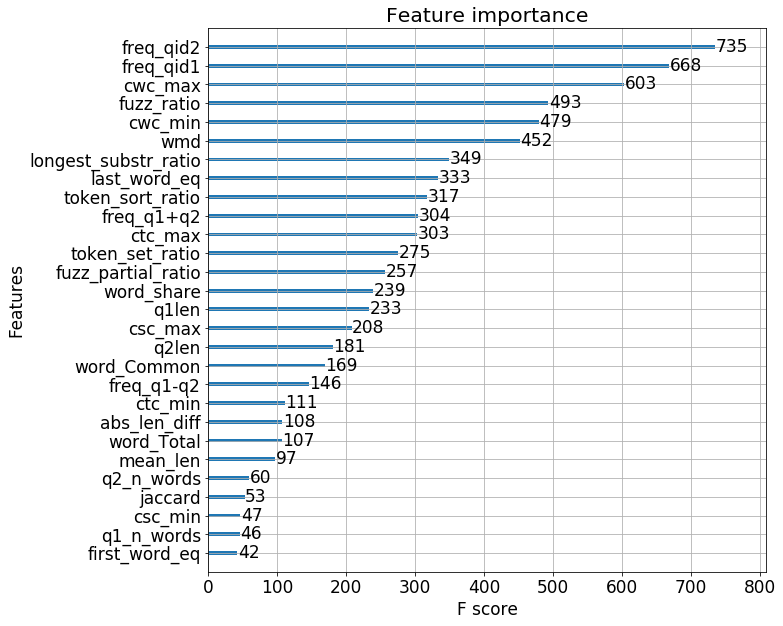

In [126]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 17})
plt.show()

In [118]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [119]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

#### Benchmark:

100k Dataset
* 78% without MinMaxScaler
* 81 with MinMaxScaler


400k Dataset
* 83 with MinMaxScaler -> probably this might have worked the same with 150-200k rows


In [120]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     84158
           1       0.79      0.74      0.76     49257

    accuracy                           0.83    133415
   macro avg       0.82      0.81      0.82    133415
weighted avg       0.83      0.83      0.83    133415



If you have an AMD Graphic Card but still want to work with neural nets and Keras you might want to use [PlaidML](https://github.com/plaidml/plaidml), think abuot it like CUDA for AMD ( Doesn't work for RNN )

In [61]:
%%capture --no-display
import keras.layers as layers
from keras.models import Model
from keras import backend as K
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [62]:
%%capture --no-display
import tensorflow as tf
import tensorflow_hub as hub

In [46]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [63]:
DROPOUT = 0.1

def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

def create_model():
    # Taking the question1 as input and ceating a embedding for each question before feed it to neural network
    q1 = layers.Input(shape=(1,), dtype=tf.string)
    embedding_q1 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q1)
    # Taking the question2 and doing the same thing mentioned above, using the lambda function
    q2 = layers.Input(shape=(1,), dtype=tf.string)
    embedding_q2 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q2)

    # Concatenating the both input layer
    merged = layers.concatenate([embedding_q1, embedding_q2])
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    # Normalizing the input layer,applying dense and dropout  layer for fully connected model and to avoid overfitting 
    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    merged = layers.BatchNormalization()(merged)
    merged = layers.Dense(200, activation='relu')(merged)
    merged = layers.Dropout(DROPOUT)(merged)

    # Using the Sigmoid as the activation function and binary crossentropy for binary classifcation as 0 or 1
    merged = layers.BatchNormalization()(merged)
    pred = layers.Dense(2, activation='sigmoid')(merged)
    model = Model(inputs=[q1,q2], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X1 = train['question1']
X2 = train['question2']
y = train['is_duplicate']
# Using the sklearn to split data in question1 and question2 train and test in the ration 80-20 %
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

train_q1 = X1_train.tolist()
train_q1 = np.array(train_q1, dtype=object)[:, np.newaxis]
train_q2 = X2_train.tolist()
train_q2 = np.array(train_q2, dtype=object)[:, np.newaxis]

train_labels = np.asarray(pd.get_dummies(y_train), dtype = np.int8)

test_q1 = X1_test.tolist()
test_q1 = np.array(test_q1, dtype=object)[:, np.newaxis]
test_q2 = X2_test.tolist()
test_q2 = np.array(test_q2, dtype=object)[:, np.newaxis]

test_labels = np.asarray(pd.get_dummies(y_test), dtype = np.int8)


In [64]:
nn_model = create_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 512)          0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 512)          0           input_12[0][0]                   
__________________________________________________________________________________________________
concatenat

In [66]:
from keras.callbacks import ModelCheckpoint

# Creating the tensorflow session to train the model and save checkpoint after every epoch.
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    filepath="models/model-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    callbacks_list = [checkpoint]
    history = nn_model.fit([train_q1, train_q2], 
            train_labels,
            validation_data=([test_q1, test_q2], test_labels),
            epochs=10,
            batch_size=512, callbacks=callbacks_list)

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 791s 10ms/step - loss: 0.5869 - acc: 0.6979 - val_loss: 0.7746 - val_acc: 0.4983
Epoch 2/10
 3072/80000 [>.............................] - ETA: 8:59 - loss: 0.4848 - acc: 0.7728

KeyboardInterrupt: 

In [69]:
q1 = input("Type Question 1 here -->")
q2 = input("Type Question 2 here -->") 
q1 = np.array([[q1],[q1]])
q2 = np.array([[q2],[q2]])
# Using the same tensorflow session for embedding the test string
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    # Loading the save weights
    nn_model.load_weights('models/model-01-0.50.hdf5')  
    # Predicting the similarity between the two input questions 
    predicts = nn_model.predict([q1, q2], verbose=0)
    predict_logits = predicts.argmax(axis=1)
    print("----FINAL RESULT----")
    if(predict_logits[0] == 1):
        print("****Questions are Similar****")
    else:
        print("****Questions are not Similar****")

Type Question 1 here --> how are you
Type Question 2 here --> are you alright


----FINAL RESULT----
****Questions are not Similar****
